In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle

In [7]:
data = pd.read_json('./Sarcasm Data/Sarcasm_Headlines_Dataset.json',lines = True)

In [8]:
df = data.drop('article_link', axis = 1)

In [9]:
counts = df['is_sarcastic'].value_counts().reset_index()
counts.columns = ['is_sarcastic', 'count']
print(counts)

   is_sarcastic  count
0             0  14985
1             1  11724


# Preprocessing

In [12]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harshal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
nlp = spacy.load('en_core_web_sm')

In [17]:
def preprocess(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    a_lemmas = [lemma.lower() for lemma in lemmas if lemma.isalpha() and lemma not in stopwords.words('english')]
    lemmatized_text = ' '.join(a_lemmas)
    return lemmatized_text

In [18]:
cleaned_text = []
for text in df.headline:
    processedtext = preprocess(text)
    cleaned_text.append(processedtext)


In [62]:
with open('cleaned_text.pkl', 'wb') as file:
    pickle.dump(cleaned_text, file)

In [63]:
with open('cleaned_text.pkl', 'rb') as file:
    loaded_cleaned_text = pickle.load(file)

In [64]:
df['clean_text'] = loaded_cleaned_text
df.head()

,headline,is_sarcastic,clean_text
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black co...
1,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood w...
2,mom starting to fear son's web series closest ...,1,mom start fear son web series close thing gran...
3,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative debt...
4,j.k. rowling wishes snape happy birthday in th...,0,rowling wish snape happy birthday magical way


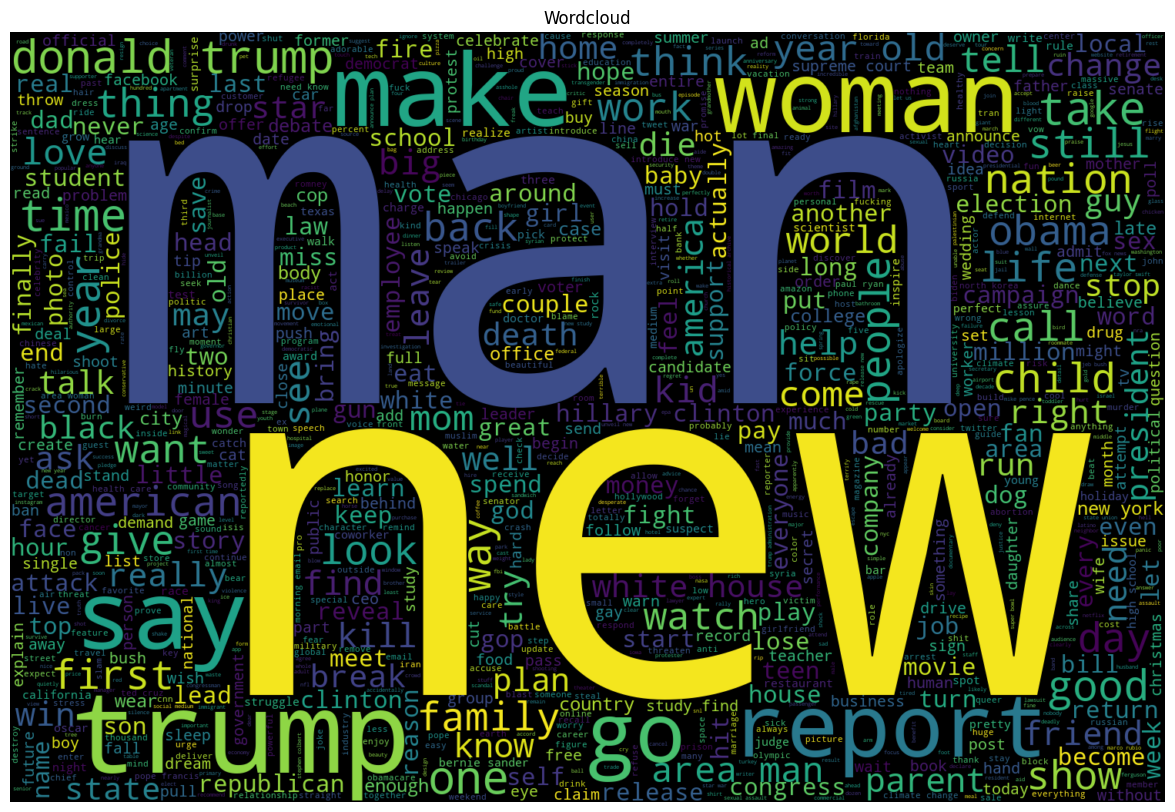

In [19]:
from wordcloud import WordCloud
plt.figure(figsize = (20,10))
wc = WordCloud(width = 1500,height = 1000,max_words = 1000).generate(' '.join(word for word in df.clean_text))
plt.axis("off")
plt.title('Wordcloud')
plt.imshow(wc , interpolation = 'bilinear')

# Model Building

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
X = df.clean_text
y = df.is_sarcastic

In [23]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

In [26]:
tfidf = TfidfVectorizer(ngram_range = (1,3))
X_tfidf_train = tfidf.fit_transform(X_train.tolist())
X_tfidf_test = tfidf.transform(X_test.tolist())

## Logistic Regression

In [27]:
## Train for the first time

lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_tfidf_train, y_train)

LogisticRegression(class_weight='balanced')

In [28]:
## Save the model as pickle file

with open('LogisticRegression.pkl', 'wb') as file:
    pickle.dump(lr, file)

In [34]:
# Load the model from pickle file

with open('LogisticRegression.pkl', 'rb') as file:
    loaded_lr = pickle.load(file)

In [35]:
y_pred_lr = loaded_lr.predict(X_tfidf_test)
print_metrices(y_pred_lr,y_test)

[[3598  885]
 [ 862 2668]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      4483
           1       0.75      0.76      0.75      3530

    accuracy                           0.78      8013
   macro avg       0.78      0.78      0.78      8013
weighted avg       0.78      0.78      0.78      8013

Accuracy :  0.7819792836640459
Precison :  0.781845008821491
Recall :  0.7819792836640459
F1 :  0.7819056615855512


## Naive Bayes

In [31]:
## Train for the first time

clf_nb = MultinomialNB()
clf_nb.fit(X_tfidf_train,y_train)

MultinomialNB()

In [32]:
## Save the model as pickle file

with open('MultinomialNB.pkl', 'wb') as file:
    pickle.dump(clf_nb, file)

In [44]:
# Load the model from pickle file

with open('MultinomialNB.pkl', 'rb') as file:
    loaded_mnb = pickle.load(file)

In [37]:
y_pred_nb = loaded_mnb.predict(X_tfidf_test)
print_metrices(y_pred_nb,y_test)

[[4251  232]
 [1686 1844]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      4483
           1       0.89      0.52      0.66      3530

    accuracy                           0.76      8013
   macro avg       0.80      0.74      0.74      8013
weighted avg       0.79      0.76      0.75      8013

Accuracy :  0.7606389616872582
Precison :  0.8379151399050805
Recall :  0.7606389616872582
F1 :  0.7749797539413773


## Linear SVC

In [38]:
linearsvc =  LinearSVC(C= 10,random_state=0,class_weight='balanced')
linearsvc.fit(X_tfidf_train,y_train)

c:\Users\Harshal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=10, class_weight='balanced', random_state=0)

In [46]:
with open('LinearSVC.pkl', 'wb') as file:
    pickle.dump(linearsvc, file)

In [47]:
with open('LinearSVC.pkl', 'rb') as file:
    loaded_lsvc = pickle.load(file)

In [48]:
y_pred_linearsvc = linearsvc.predict(X_tfidf_test)
print_metrices(y_pred_linearsvc,y_test)

[[3713  770]
 [ 828 2702]]
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      4483
           1       0.78      0.77      0.77      3530

    accuracy                           0.80      8013
   macro avg       0.80      0.80      0.80      8013
weighted avg       0.80      0.80      0.80      8013

Accuracy :  0.8005740671408961
Precison :  0.8010286351694653
Recall :  0.8005740671408961
F1 :  0.8007591386593901


## SVC

In [49]:
svc =  SVC(C= 10,random_state=0,class_weight='balanced')
svc.fit(X_tfidf_train,y_train)

SVC(C=10, class_weight='balanced', random_state=0)

In [50]:
with open('SVC.pkl', 'wb') as file:
    pickle.dump(svc, file)

In [56]:
with open('SVC.pkl', 'rb') as file:
    loaded_svc = pickle.load(file)

In [55]:
y_pred_svc = loaded_svc.predict(X_tfidf_test)
print_metrices(y_pred_svc,y_test)

[[3842  641]
 [1018 2512]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      4483
           1       0.80      0.71      0.75      3530

    accuracy                           0.79      8013
   macro avg       0.79      0.78      0.79      8013
weighted avg       0.79      0.79      0.79      8013

Accuracy :  0.7929614376637963
Precison :  0.7998023273488676
Recall :  0.7929614376637963
F1 :  0.7946240324891938


# Evaluation

In [58]:
acc_table = {
    'Logistic Regression' : accuracy_score(y_pred_lr,y_test),
    'Naive Bayes' : accuracy_score(y_pred_nb,y_test),
    'Linear SVC' : accuracy_score(y_pred_linearsvc,y_test),
    'SVC' : accuracy_score(y_pred_svc,y_test)
}

In [59]:
acc_df = pd.DataFrame(acc_table.items(),columns = ['Model','Accuracy'])

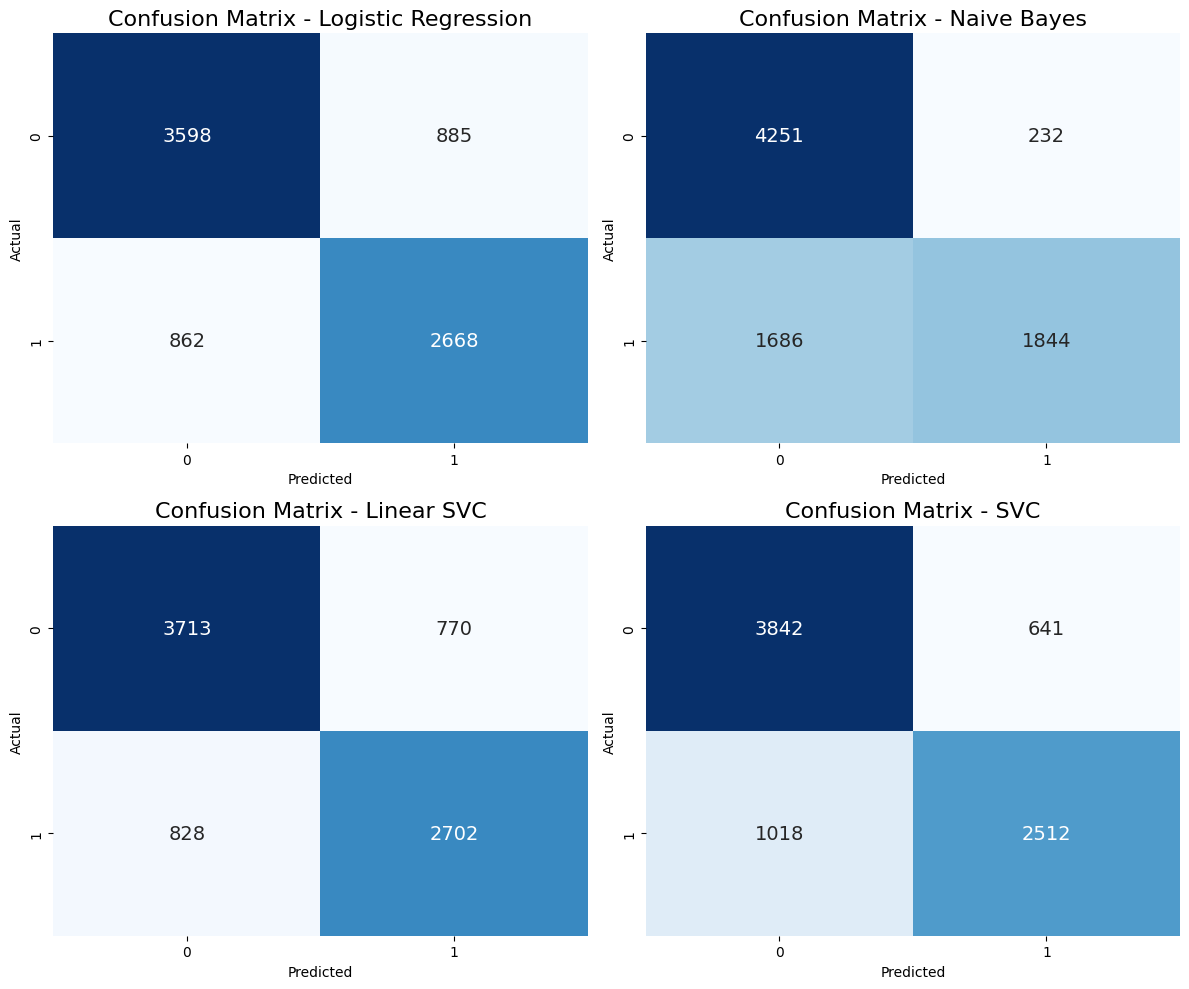

In [60]:
models = ['Logistic Regression', 'Naive Bayes', 'Linear SVC', 'SVC']
confusion_matrices = [confusion_matrix(y_test, y_pred_lr),
                      confusion_matrix(y_test, y_pred_nb),
                      confusion_matrix(y_test, y_pred_linearsvc),
                      confusion_matrix(y_test, y_pred_svc)]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (model, cm) in enumerate(zip(models, confusion_matrices)):
    ax = axes[i // 2, i % 2]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14},
                xticklabels=df.is_sarcastic.unique(), yticklabels=df.is_sarcastic.unique(), ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {model}', fontsize=16)

plt.tight_layout()
plt.show()

In [61]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Naive Bayes', 'Linear SVC', 'SVC'],
    'Accuracy': [accuracy_score(y_pred_lr,y_test).round(4), accuracy_score(y_pred_nb,y_test).round(4) , accuracy_score(y_pred_linearsvc,y_test).round(4), accuracy_score(y_pred_svc,y_test).round(4)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Linear SVC,0.8006
1,SVC,0.7930
2,Logistic Regression,0.7820
3,Naive Bayes,0.7606
